In [1]:
import pickle 
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from pygsti.modelpacks import smq2Q_XYCNOT as std
import pygsti

# setup the FOGI model -- just to get the labels actually
mdl_datagen = std.target_model('H+s')
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, mdl_datagen.state_space, elementary_errorgen_types='HS')
mdl_datagen.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
target_model = mdl_datagen.copy()

In [3]:
with open('parameter_history_2q' + '.pickle', 'rb') as f:
    param_hist =  pickle.load(f)
with open('covar_history_2q' + '.pickle', 'rb') as f:
    covar_hist =  pickle.load(f)
with open('mle_param_estimates_2q' + '.pickle', 'rb') as f:
    estimates =  pickle.load(f)
with open('mdl_datagen_vector_2q' + '.pickle', 'rb') as f:
    datagen_vec =  pickle.load(f)

In [4]:
def square_error(x1, x2):
    return sum((x1[i] - x2[i])**2 for i in range(len(x1)))

def absolute_error(x1, x2):
    return sum(abs(x1[i] - x2[i]))

In [5]:
# set germ circuit ranges for the mle batches
germ_length_ranges = {
    0: [0, 731], 
    1: [731, 1509], 
    2: [1509, 2999], 
    3: [2999, 5427], 
    4: [5427, 7860], 
    5: [7860, 10293]
}

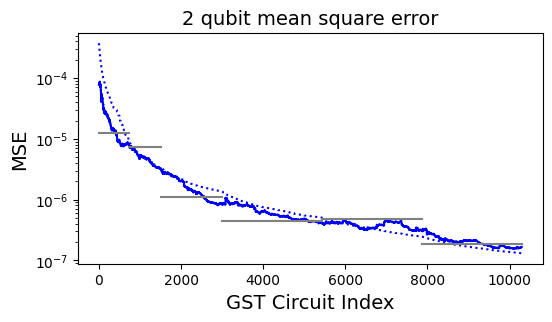

In [15]:
# MSE evolution plots
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot()
ax.set_title('2 qubit mean square error', fontsize=14)

true_params = mdl_datagen.to_vector()
ekf_error = []
ekf_uncert = []

for i in range(len(param_hist)):
    ekf_error.append( ((param_hist[i]-datagen_vec)@(param_hist[i]-datagen_vec))/len(param_hist[i])) 
    ekf_uncert.append( (np.trace(covar_hist[i])/len(param_hist[i]))  ) 



ekf_uline, = ax.semilogy(ekf_uncert, c='blue', linestyle='dotted')
ekf_line, = ax.plot(ekf_error, c='blue', linestyle='solid')

for i, evec in enumerate(estimates):
    mle_error = (evec - datagen_vec)@(evec-datagen_vec)/len(param_hist[i])
    mle_line, = plt.plot(germ_length_ranges[i], (mle_error, mle_error), c='gray', label='MLE Estimate')
ax.set_xlabel('GST Circuit Index', fontsize=14)
ax.set_ylabel('MSE', fontsize=14)
plt.savefig('../Figures/2qMSE.eps', dpi=350, format="eps", bbox_inches='tight')

/tmp/ipykernel_3843/3097974695.py:12: RuntimeWarning: invalid value encountered in sqrt
  ekf_uncert.append( (np.trace(np.sqrt(covar_hist[i]))/len(param_hist[i]))  )


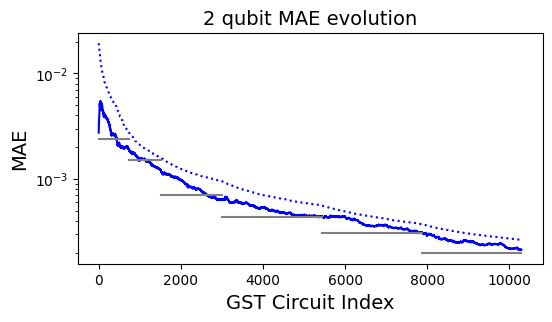

/tmp/ipykernel_3843/3146589503.py:12: RuntimeWarning: invalid value encountered in sqrt
  ekf_uncert.append( (np.trace(np.sqrt(covar_hist[i]))/len(param_hist[i]))  )


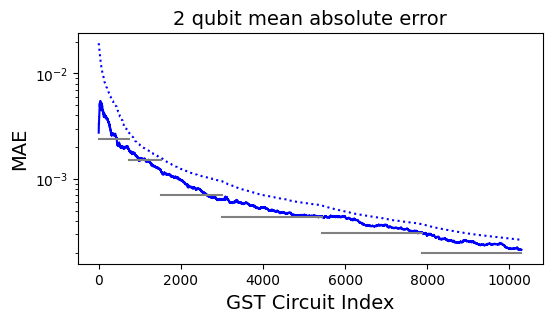

In [10]:
# MAE (mean absolute error) evolution plots
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot()
ax.set_title('2 qubit mean absolute error', fontsize=14)

true_params = mdl_datagen.to_vector()
ekf_error = []
ekf_uncert = []

for i in range(len(param_hist)):
    ekf_error.append( sum(abs((param_hist[i]-datagen_vec))) /len(param_hist[i]) ) 
    ekf_uncert.append( (np.trace(np.sqrt(covar_hist[i]))/len(param_hist[i]))  ) 


ekf_uline, = ax.semilogy(ekf_uncert, c='blue', linestyle='dotted')
ekf_line, = ax.plot(ekf_error, c='blue', linestyle='solid')

for i, evec in enumerate(estimates):
    mle_error = sum(abs(evec - datagen_vec))/len(evec)
    mle_line, = plt.plot(germ_length_ranges[i], (mle_error, mle_error), c='gray', label='MLE Estimate')
ax.set_xlabel('GST Circuit Index', fontsize=14)
ax.set_ylabel('MAE', fontsize=14)
plt.savefig('../Figures/2qMAE.eps', dpi=350, format="eps", bbox_inches='tight')

# Hamiltonian errors

In [11]:
fogi_labels = mdl_datagen.fogi_errorgen_component_labels(typ='raw')
labels = [
    'H(X:1)_Gxpi2:1',
    'H(Y:1)_Gypi2:1',
    'H(X:0)_Gxpi2:0',
    'H(Y:0)_Gypi2:0',
    'H(ZX:01)_Gcnot:0:1'
]
for lbl in labels:
    print(lbl, 'has index',fogi_labels.index(lbl),)


estimate_dict = dict()
uncert_dict = dict()
for lbl in labels:
    estimate_dict[lbl] = np.zeros(len(param_hist))
    uncert_dict[lbl] = np.zeros(len(param_hist))
    for i in range(len(param_hist)):
        estimate_dict[lbl][i] = param_hist[i][fogi_labels.index(lbl)]
        uncert_dict[lbl][i] = np.sqrt(covar_hist[i][fogi_labels.index(lbl), fogi_labels.index(lbl)])

H(X:1)_Gxpi2:1 has index 0
H(Y:1)_Gypi2:1 has index 18
H(X:0)_Gxpi2:0 has index 39
H(Y:0)_Gypi2:0 has index 57
H(ZX:01)_Gcnot:0:1 has index 80
H(X:1)_Gxpi2:1 has index 0
H(Y:1)_Gypi2:1 has index 18
H(X:0)_Gxpi2:0 has index 39
H(Y:0)_Gypi2:0 has index 57
H(ZX:01)_Gcnot:0:1 has index 80


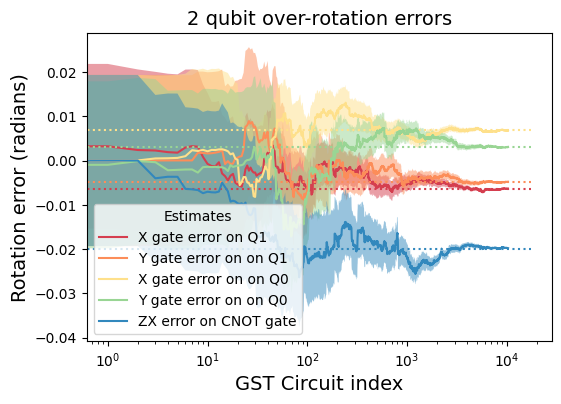

In [14]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()
ax.set_title('2 qubit over-rotation errors', fontsize=14)

#[,,,'#e6f598',,]
linelables_and_colors = {
    'X gate error on Q1': '#d53e4f',
    'Y gate error on on Q1': '#fc8d59',
    'X gate error on on Q0': '#fee08b',
    'Y gate error on on Q0': '#99d594',
    'ZX error on CNOT gate' : '#3288bd'
}

lines = []
for idx, lbl in enumerate(linelables_and_colors.keys()):
    line, = plt.semilogx(estimate_dict[labels[idx]], c=linelables_and_colors[lbl])
    lines.append(line)
    ax.fill_between(range(len(param_hist)), estimate_dict[labels[idx]]-uncert_dict[labels[idx]], estimate_dict[labels[idx]]+uncert_dict[labels[idx]], alpha=0.5, color=linelables_and_colors[lbl], linewidth=0.0)
    ax.semilogx((0, len(param_hist)+7000), (datagen_vec[fogi_labels.index(labels[idx])], datagen_vec[fogi_labels.index(labels[idx])]), c=linelables_and_colors[lbl], linestyle='dotted')
plt.legend(lines, linelables_and_colors.keys(), title='Estimates')

ax.set_xlabel('GST Circuit index', fontsize=14)
ax.set_ylabel('Rotation error (radians)', fontsize=14)
plt.savefig('../Figures/2qOverrot.png', dpi=350, format="png", bbox_inches='tight')